http://intomath.org/wp-content/uploads/2021/03/Fx-ab-c.jpg

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
!pip install wandb
import wandb
!wandb login
import os
import seaborn as sns
import plotly.express as px
import math as m
from scipy.stats import norm
euler = m.e
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 145 kB 45.5 MB/s 
     |████████████████████████████████| 181 kB 45.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f49d6f110be320e42489ab74fd4ae54dedbfa108f39cd824922b422a982928d8
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="exponentials", entity="sophied")
sweep_config = {'method': 'bayes'}
metric = {'name': 'branch_loss', 'goal': 'minimize'}
sweep_config['metric'] = metric
parameters_dict = {
    'branch_weight': {
        'min': 1,
        'max': 100,
        'distribution': 'uniform'
    },
    'kl_weight': {
        'min': .001,
        'max': 1,
        'distribution': 'uniform'
    },
    'learning_rate': {
        'min': 0.0001,
        'max': 0.005,
        'distribution': 'uniform'
    },
    'ae_layer': {
        'min': 7,
        'max': 20,
        'distribution': 'int_uniform'
    },
    'branch_layer': {
        'min': 4,
        'max': 10,
        'distribution': 'int_uniform'
    }
}

sweep_config['parameters'] = parameters_dict
import pprint
pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="exponentials")

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'branch_loss'},
 'parameters': {'ae_layer': {'distribution': 'int_uniform',
                             'max': 20,
                             'min': 7},
                'branch_layer': {'distribution': 'int_uniform',
                                 'max': 10,
                                 'min': 4},
                'branch_weight': {'distribution': 'uniform',
                                  'max': 100,
                                  'min': 1},
                'kl_weight': {'distribution': 'uniform',
                              'max': 1,
                              'min': 0.001},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.005,
                                  'min': 0.0001}}}
Create sweep with ID: 5e99jgaj
Sweep URL: https://wandb.ai/sophied/exponentials/sweeps/5e99jgaj


In [ ]:
class DL:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

In [ ]:
def gen_data(A=True, B=True, C=True, D=True, size=10000):
  if A==True: 
    a = np.concatenate((np.random.uniform(low=-3, high=-0.1, size=int(size/2)).tolist(), np.random.uniform(low=0.1, high=3, size=int(size/2))), axis=0)
    np.random.shuffle(a)
  else:
    a = np.full(shape=size, fill_value=1,dtype=float)
  if B==True: 
    b = np.random.uniform(low=1/(euler), high=(euler), size=int(size))
    np.random.shuffle(b)
  else:
    b = np.full(shape=size, fill_value=euler,dtype=float)
  if C==True: 
    c = np.random.uniform(low=-3, high=3, size=size).tolist()
  else:
    c = np.full(shape=size, fill_value=0,dtype=float)
  if D==True: 
    d = np.random.uniform(low=-euler, high=euler, size=size)
  else:
    d = np.full(shape=size, fill_value=0,dtype=float)
  mlist = []
  for i, t in enumerate(a):
    mlist.append([a[i]*(b[i]**(x-d[i]))+c[i] for x in np.arange(-euler,euler,euler/50)])
  data = pd.DataFrame(mlist)

  data['a'] = a
  data['b'] = b
  data['c'] = c
  data['d'] = d
  return data

def norm(t):
  # return (t-torch.mean(t))/torch.std(t)
  return (t-torch.min(t))/(torch.max(t)-torch.min(t))

def plot_data(data):
  x1 = [x for x in np.arange(-euler, euler, euler/50)]
  for index, row in data.drop(columns=['a', 'b', 'c', 'd']).iterrows():
    plt.plot(x1, row) 
  plt.ylim(-10, 10)
  plt.xlim(-euler, euler-euler/50)

def split_data(data): 
  msk = np.random.rand(len(data)) < 0.8
  train = data[msk]
  test = data[~msk]
  msk2 = np.random.rand(len(test)) < 0.8
  validate = test[~msk2]
  test = test[msk2]

  train_data = torch.tensor(train.values, requires_grad=True, dtype=torch.float32)
  test_data = torch.tensor(test.values, requires_grad=True, dtype=torch.float32)
  validate_data = torch.tensor(validate.values, requires_grad=True, dtype=torch.float32)

  trains = {
  'X': norm(train_data[:, :100]),
  'A': norm(train_data[:, 100:101].unsqueeze(dim=1)),
  'B': norm(train_data[:, 101:102].unsqueeze(dim=1)),
  'C': norm(train_data[:, 102:103].unsqueeze(dim=1)),
  'D': norm(train_data[:, 103:].unsqueeze(dim=1))
  }

  tests = {
  'X': norm(test_data[:, :100]),
  'A': norm(test_data[:, 100:101].unsqueeze(dim=1)),
  'B': norm(test_data[:, 101:102].unsqueeze(dim=1)),
  'C': norm(test_data[:, 102:103].unsqueeze(dim=1)),
  'D': norm(test_data[:, 103:].unsqueeze(dim=1))
  }

  X_val = validate_data[:, :100].mul(0.1)
  Exp_val = validate_data[:, 100:101].unsqueeze(dim=1)
  Coef_val = validate_data[:, 101:].unsqueeze(dim=1)
  return trains, tests

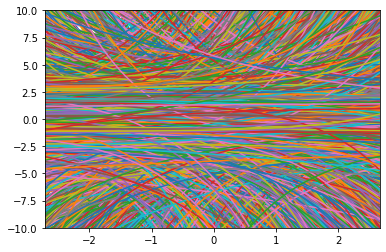

In [ ]:
data = gen_data(A=True, B=True, C=True, D=True)
trains, tests = split_data(data)
plot_data(data)

In [ ]:
# class Calico(torch.nn.Module):
#   def __init__(self, latent_dim, ae_layer, branch_layer, end_dim):
#     super().__init__()
#     self.encoder = torch.nn.Sequential(
#         torch.nn.Linear(100, ae_layer),
#         torch.nn.ReLU(),
#         torch.nn.Linear(ae_layer, latent_dim)
#     )
#     self.decoder = torch.nn.Sequential(
#         torch.nn.ReLU(),
#         torch.nn.Linear(latent_dim, ae_layer),
#         torch.nn.ReLU(),
#         torch.nn.Linear(ae_layer, 100),
#         torch.nn.Sigmoid()
#     )
#     self.branch = torch.nn.Sequential(
#         torch.nn.ReLU(),
#         torch.nn.Linear(latent_dim, branch_layer),
#         torch.nn.ReLU(),
#         torch.nn.Linear(branch_layer, end_dim),
#         torch.nn.Sigmoid()
#     )

#   def reparameterize(self, mu, log_var):
#     std = torch.exp(0.5*log_var)
#     eps = torch.randn_like(std)
#     sample = mu + (eps * std)
#     return sample

#   def forward(self, x):
#     ls = self.encoder(x)#.unsqueeze(dim=2)

#     mu = ls[:, 0] 
#     log_var = ls[:, 1]

#     ls = self.reparameterize(mu, log_var)
#     return ls, self.decoder(ls), self.branch(ls)

In [ ]:
class Calico(torch.nn.Module):
    def __init__(self, latent_dim, ae_layer, branch_layer, end_dim):
        super().__init__()
 
        self.enc1 = torch.nn.Linear(in_features=100, out_features=ae_layer)
        self.enc2 = torch.nn.Linear(in_features=ae_layer, out_features=latent_dim*2)
 
        self.dec1 = torch.nn.Linear(in_features=latent_dim, out_features=ae_layer)
        self.dec2 = torch.nn.Linear(in_features=ae_layer, out_features=100)
        self.latent_dim = latent_dim

        self.branch1 = torch.nn.Linear(in_features=latent_dim, out_features=branch_layer)
        self.branch2 = torch.nn.Linear(in_features=branch_layer, out_features=end_dim)

    def reparameterize(self, mu, sigma):
        std = torch.exp(sigma/2)
        epsilon = torch.randn_like(std)
        sample = mu + (epsilon * std) 
        return sample
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.enc1(x))
        x = self.enc2(x)
        x = x.view(-1, 2, self.latent_dim)

        mu = x[:, 0, :] # mean
        sigma = x[:, 1, :] # variance

        ls = self.reparameterize(mu, sigma)
 
        # decoding
        x = torch.nn.functional.relu(self.dec1(ls))
        reconstruction = torch.sigmoid(self.dec2(x))
        
        #branch
        preds = torch.nn.functional.relu(self.branch1(ls))
        preds = torch.sigmoid(self.branch2(preds))

        return ls, reconstruction, preds, mu, sigma

In [ ]:

def train(x=trains['X'], a=torch.cat((trains['A'], trains['B'], trains['C'], trains['D']), axis=1)):
  with wandb.init(config=None):
    config = wandb.config
    model = Calico(10, config.ae_layer, config.branch_layer, 4)
    wandb.log({'vars': 'A+B+C+D'})
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    train_batches = DL(x, a, batch_size=64, shuffle=False)
    for epoch in range(30):
      for idx, batch in enumerate(train_batches):
        optimizer.zero_grad()
        ls, recon, pred, mu, sigma = model(batch[0])
        recon_loss = torch.nn.MSELoss()(recon, batch[0])
        branch_loss = torch.nn.MSELoss()(pred.squeeze(), batch[1].squeeze())
        kl = torch.nn.KLDivLoss(reduction='sum')(torch.nn.functional.log_softmax(pred.squeeze(), -1), batch[1].squeeze())#self.kl(mu, sigma)
        loss = recon_loss + config.branch_weight*branch_loss + config.kl_weight*kl
        loss.backward(retain_graph=True)
        optimizer.step()
        wandb.log({'loss': loss, 'recon_loss': recon_loss, 'branch_loss': branch_loss, 'kl': kl})

In [ ]:
wandb.agent(sweep_id, train, count=1000)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: s85jzx6g with config:
wandb: 	ae_layer: 11
wandb: 	branch_layer: 7
wandb: 	branch_weight: 11.842802074203842
wandb: 	kl_weight: 0.365869298614495
wandb: 	learning_rate: 0.00042077996561355985


branch_loss,▄▇▃▄▄▃█▇▄▃▃█▅▄▅▅▅▃▅▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▆▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▅▃▃▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08921
kl,93.50218
loss,35.26619
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: ux9cu573 with config:
wandb: 	ae_layer: 19
wandb: 	branch_layer: 4
wandb: 	branch_weight: 8.525108932716588
wandb: 	kl_weight: 0.11694481830039806
wandb: 	learning_rate: 0.004071797001224831


branch_loss,▄▆▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,▅▂▂▂▂▂▂▂▂▃▃▁▅▃▁▃▂▂▃▃▄▁▁▁█▃▂▂▂▁▃▁▁▂▄▂▁▁▁▂
branch_loss,0.08946
kl,93.52229
loss,11.69967
recon_loss,9e-05
vars,A+B+C+D


wandb: Agent Starting Run: ylfp43nd with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 7
wandb: 	branch_weight: 12.286521271161554
wandb: 	kl_weight: 0.7271296515393024
wandb: 	learning_rate: 0.00151045644108034


branch_loss,▃▇▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▃▆▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08774
kl,93.36115
loss,68.96376
recon_loss,0.00011
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vtmhz0ix with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 7
wandb: 	branch_weight: 7.947343964805256
wandb: 	kl_weight: 0.6161928294427942
wandb: 	learning_rate: 0.001094609289251195


branch_loss,▃█▃▄▃▄▇▆▄▃▃▇▅▄▅▄▅▃▅▆▆▅▄▆▆▇▃▂▄▃▄▃▁▃▆▂▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08875
kl,93.48289
loss,58.30894
recon_loss,9e-05
vars,A+B+C+D


wandb: Agent Starting Run: h5gum1jg with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 7
wandb: 	branch_weight: 6.69259897208894
wandb: 	kl_weight: 0.8515729174426202
wandb: 	learning_rate: 0.0014713384670720986


branch_loss,▅▆▄▅▄▅█▇▅▄▄█▆▅▆▆▅▄▆▇▇▆▅▇▇█▄▄▅▅▅▄▂▃▅▁▂▂▃▂
kl,▄▄▄▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▄▄▄▃▆▂▅▄█▅▃▂▃▃▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
recon_loss,█▄▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07912
kl,91.66716
loss,78.59082
recon_loss,6e-05
vars,A+B+C+D


wandb: Agent Starting Run: 8dzrfgmc with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 4
wandb: 	branch_weight: 46.08342845371297
wandb: 	kl_weight: 0.09087253129399175
wandb: 	learning_rate: 0.0003393154508768789


branch_loss,▇▇▃▆▂▅█▇▃▃▃█▅▄▅▅▅▃▅▆▆▅▃▆▇█▃▃▄▃▅▃▁▄▆▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▅▅▃▄▅▂▆▅▇▅▃▃▄▃▃▆▃▄▄▄▄▄▅▃█▅▃▅▄▄▄▄▅▃▄▁▅▃▅▅
recon_loss,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08938
kl,93.51797
loss,12.61732
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: 8u135lts with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 8
wandb: 	branch_weight: 64.69056278792833
wandb: 	kl_weight: 0.6386585107416064
wandb: 	learning_rate: 0.0016827570023662068


branch_loss,▄▇▅▆▅▆█▇▆▅▅█▆▆▆▆▆▅▇▇▇▆▅▇▇▆▃▄▆▄▃▄▂▃▄▂▁▃▃▂
kl,▄▄▄▃▆▂▅▅█▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▄▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
recon_loss,█▃▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07592
kl,91.3503
loss,63.25299
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: lhoymyyk with config:
wandb: 	ae_layer: 16
wandb: 	branch_layer: 10
wandb: 	branch_weight: 58.544618930098665
wandb: 	kl_weight: 0.6570104929031179
wandb: 	learning_rate: 0.0010157963047341518


branch_loss,▄▆▃▅▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▆▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▃▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.0893
kl,93.51604
loss,66.6689
recon_loss,9e-05
vars,A+B+C+D


wandb: Agent Starting Run: xnnyb5et with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 10
wandb: 	branch_weight: 71.63684736436925
wandb: 	kl_weight: 0.7947028874516129
wandb: 	learning_rate: 0.004074340319369007


branch_loss,▃▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▁▁▂▁▂▂▂▁▂▂▁▃▂▁▂▁▁▂▂▂▁▁▁▄▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.08947
kl,93.52287
loss,80.73268
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: ofmt0tb1 with config:
wandb: 	ae_layer: 19
wandb: 	branch_layer: 4
wandb: 	branch_weight: 71.22234938496602
wandb: 	kl_weight: 0.3050488475857675
wandb: 	learning_rate: 0.003450932669771329


branch_loss,▅█▅▆▅▆█▇▆▅▅█▆▆▆▆▆▅▇▇▇▆▆▅▅▆▃▅▄▃▂▂▁▁▃▁▂▃▂▂
kl,▅▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▅▃▅▅
loss,▅▅▄▄▆▃▆▅█▆▄▄▄▃▄▆▄▅▄▄▅▅▆▃█▅▃▆▄▅▃▄▆▃▄▁▅▃▄▅
recon_loss,█▃▃▃▂▃▃▃▂▃▄▂▄▃▂▄▃▃▄▃▄▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07804
kl,91.30897
loss,33.41164
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: 6yaz07un with config:
wandb: 	ae_layer: 19
wandb: 	branch_layer: 5
wandb: 	branch_weight: 73.0539551483805
wandb: 	kl_weight: 0.32337972593348874
wandb: 	learning_rate: 0.003711408734601629


branch_loss,▅▇▅▆▅▆█▇▆▆▅█▇▆▇▆▆▅▇▇▇▆▆▆▆▆▄▃▄▃▄▃▂▂▃▂▁▃▃▄
kl,▄▄▄▃▆▂▆▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▅▅▄▄▆▃▆▅█▅▄▄▄▃▄▆▄▅▄▄▅▅▆▃█▄▃▅▄▄▃▄▆▃▃▁▄▃▄▅
recon_loss,█▂▂▃▂▃▃▃▂▃▄▂▅▃▁▄▃▂▃▃▅▂▂▁▅▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂
branch_loss,0.0748
kl,91.09339
loss,34.92244
recon_loss,4e-05
vars,A+B+C+D


wandb: Agent Starting Run: 9jz73x3r with config:
wandb: 	ae_layer: 19
wandb: 	branch_layer: 6
wandb: 	branch_weight: 73.479853538611
wandb: 	kl_weight: 0.4016266676907641
wandb: 	learning_rate: 0.003919793469043543


branch_loss,▃▇▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,▆▁▂▂▂▂▂▂▂▃▃▁▄▃▁▃▂▂▃▃▄▁▁▁█▃▂▂▂▁▃▁▁▂▄▂▁▁▂▂
branch_loss,0.08947
kl,93.52434
loss,44.13603
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: xjsmzecr with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 8
wandb: 	branch_weight: 69.10715800254374
wandb: 	kl_weight: 0.03215998460311862
wandb: 	learning_rate: 0.0039684734655587


branch_loss,▅▇▅▆▅▆█▇▆▆▅█▇▆▆▆▆▄▄▅▅▄▃▄▄▆▃▂▃▃▃▃▁▁▃▁▁▁▂▂
kl,▄▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▅▇▅▆▆▅█▇▇▆▅▇▆▅▆▇▅▅▄▅▅▅▄▃▆▆▃▄▄▄▃▄▃▂▃▁▂▂▃▃
recon_loss,█▂▃▃▃▃▃▃▂▄▄▂▆▄▂▃▂▁▁▁▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
branch_loss,0.06723
kl,90.86776
loss,7.56851
recon_loss,4e-05
vars,A+B+C+D


wandb: Agent Starting Run: n77580qe with config:
wandb: 	ae_layer: 11
wandb: 	branch_layer: 8
wandb: 	branch_weight: 76.2372628829918
wandb: 	kl_weight: 0.8081357744220111
wandb: 	learning_rate: 0.0012174937541720484


branch_loss,▄▆▃▄▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
branch_loss,0.0896
kl,93.55589
loss,82.43661
recon_loss,0.0001
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ro22hv92 with config:
wandb: 	ae_layer: 7
wandb: 	branch_layer: 7
wandb: 	branch_weight: 95.7616394620578
wandb: 	kl_weight: 0.4496201595379174
wandb: 	learning_rate: 0.00261980910087083


branch_loss,▅█▅▆▅▆█▇▆▆▅█▇▆▆▆▇▅▆▇▆▆▄▅▅▇▄▂▄▃▄▃▂▃▃▁▁▂▂▄
kl,▅▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▅▅▄▄▆▃▆▅█▅▄▄▄▃▄▆▄▅▄▄▅▅▅▃█▅▃▅▄▄▃▅▆▃▄▁▅▃▄▅
recon_loss,█▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.0774
kl,91.01363
loss,48.33352
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: lbvsp2se with config:
wandb: 	ae_layer: 18
wandb: 	branch_layer: 5
wandb: 	branch_weight: 57.79292141102271
wandb: 	kl_weight: 0.04973968888078692
wandb: 	learning_rate: 0.0019042829562684344


branch_loss,▅█▄▆▄▅█▇▅▅▄█▆▅▆▆▆▄▆▇▇▆▅▇▇█▄▅▆▅▅▄▂▄▅▁▃▂▂▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▄▅▆▃▄▁▅▃▄▅
loss,▅▆▄▄▅▃▇▆▇▅▄▅▅▄▄▆▄▅▅▅▅▅▅▅█▆▄▅▅▅▄▅▅▄▄▁▄▂▃▄
recon_loss,█▂▁▂▁▂▂▂▁▂▂▁▂▂▁▂▁▁▂▂▂▁▁▁▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07762
kl,91.79008
loss,9.05176
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: zzpk0mud with config:
wandb: 	ae_layer: 10
wandb: 	branch_layer: 10
wandb: 	branch_weight: 7.910094128982519
wandb: 	kl_weight: 0.6616971501829381
wandb: 	learning_rate: 0.001350261288015207


branch_loss,▅▇▃▅▄▅█▇▅▅▄█▆▅▆▆▆▄▆▇▇▆▅▇▇█▄▄▅▄▅▄▂▅▆▂▂▂▂▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
recon_loss,█▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07775
kl,91.64579
loss,61.25683
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: kug2tdez with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 7
wandb: 	branch_weight: 79.12448271782853
wandb: 	kl_weight: 0.6045382611692802
wandb: 	learning_rate: 0.002985551955375923


branch_loss,▄▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▂▃▃▁▄▃▁▃▂▂▂▃▄▁▁▁█▂▂▂▂▁▃▁▁▂▄▂▁▁▁▂
branch_loss,0.08941
kl,93.51754
loss,63.60923
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: xgnvexvt with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 4
wandb: 	branch_weight: 15.40800143745242
wandb: 	kl_weight: 0.5506015546058736
wandb: 	learning_rate: 0.001078703601577561


branch_loss,▅▇▂▄▂▄█▇▄▄▃█▆▄▅▅▅▃▅▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08918
kl,93.51092
loss,52.86141
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: lbh5in2k with config:
wandb: 	ae_layer: 19
wandb: 	branch_layer: 8
wandb: 	branch_weight: 18.6044502176784
wandb: 	kl_weight: 0.1478753925599494
wandb: 	learning_rate: 0.001082332550435935


branch_loss,▄▆▂▄▃▄█▇▄▄▃█▅▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▃▄▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▅▆▃▄▁▅▃▅▅
recon_loss,█▃▂▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
branch_loss,0.08511
kl,93.13162
loss,15.35538
recon_loss,6e-05
vars,A+B+C+D


wandb: Agent Starting Run: 5tjclcbk with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 8
wandb: 	branch_weight: 92.20482784081165
wandb: 	kl_weight: 0.8011564936378843
wandb: 	learning_rate: 0.004561361376211889


branch_loss,▄▆▄▅▄▅▇▆▅▅▅▇▆▅▆▅▅▅▆▆▆▅▄▄██▄▂▄▃▄▃▂▃▃▁▂▃▂▆
kl,▅▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▆
loss,▅▅▄▄▆▃▆▅█▅▄▃▄▃▄▆▄▅▄▄▄▄▅▃█▅▃▅▄▄▃▄▆▃▃▁▅▃▄▆
recon_loss,█▂▂▃▂▃▃▃▂▃▄▁▅▃▁▃▃▂▄▃▅▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07159
kl,90.58774
loss,79.17555
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: ggeo1zps with config:
wandb: 	ae_layer: 16
wandb: 	branch_layer: 8
wandb: 	branch_weight: 37.64139463147612
wandb: 	kl_weight: 0.9129766282551792
wandb: 	learning_rate: 0.002575914743012861


branch_loss,▅▇▅▆▅▆█▇▆▅▅█▇▆▆▆▆▅▇▇▇▆▅▇▅▆▃▃▅▃▃▄▂▂▃▁▂▃▂▃
kl,▅▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▅▅▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▃▂▁▂▂▂▂▂▃▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07642
kl,90.95805
loss,85.91919
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: h9ay1for with config:
wandb: 	ae_layer: 16
wandb: 	branch_layer: 8
wandb: 	branch_weight: 6.512304954416728
wandb: 	kl_weight: 0.6043000199157479
wandb: 	learning_rate: 0.0037964076745272217


branch_loss,▄▇▂▄▃▄█▇▄▄▃█▅▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▂▃▃▁▄▃▁▃▂▂▂▂▄▁▁▁█▃▂▂▂▁▃▁▁▂▄▂▁▁▁▂
branch_loss,0.08933
kl,93.51627
loss,57.0937
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: gyaqsin3 with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 8
wandb: 	branch_weight: 80.44686826824496
wandb: 	kl_weight: 0.4943435688836882
wandb: 	learning_rate: 0.004901223982880385


branch_loss,▃▇▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▅▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▄▃▁▃▂▂▂▂▄▁▁▁▇▂▂▁▂▁▃▂▁▂▃▂▁▁▁▂
branch_loss,0.08959
kl,93.5289
loss,53.44277
recon_loss,8e-05
vars,A+B+C+D


wandb: Agent Starting Run: z78tf6gv with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 5
wandb: 	branch_weight: 2.454825449714396
wandb: 	kl_weight: 0.4837292310996009
wandb: 	learning_rate: 0.0014517414596853296


branch_loss,▄▆▃▄▃▄█▇▄▄▃▇▅▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▄▃▁▄▆▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08911
kl,93.51476
loss,45.45467
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: c77b95y6 with config:
wandb: 	ae_layer: 16
wandb: 	branch_layer: 9
wandb: 	branch_weight: 38.16030249042358
wandb: 	kl_weight: 0.32640057601309713
wandb: 	learning_rate: 0.0009980353313068311


branch_loss,▆▇▅▆▅▆█▇▅▅▅█▆▆▆▆▆▅▆▇▇▆▅▇▇█▅▄▆▅▄▄▂▁▃▁▁▂▃▃
kl,▄▄▄▃▆▂▅▄█▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▄▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▅▃▆▄▅▃▅▆▃▃▁▅▃▄▅
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.0744
kl,91.30063
loss,32.63976
recon_loss,5e-05
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wwba0t4z with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 5
wandb: 	branch_weight: 79.34806357925646
wandb: 	kl_weight: 0.9771621527547012
wandb: 	learning_rate: 0.003727544380086189


branch_loss,▄▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▁▁▁▁▁▁▁▂▂▁▂▂▁▂▁▁▂▂▂▁▁▁▄▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.08944
kl,93.5206
loss,98.48155
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: 5pjibq93 with config:
wandb: 	ae_layer: 14
wandb: 	branch_layer: 4
wandb: 	branch_weight: 92.89862055258862
wandb: 	kl_weight: 0.7101716294463207
wandb: 	learning_rate: 0.0015789754465418378


branch_loss,▃█▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▄▃▁▄▇▁▃▃▄▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.08716
kl,93.28718
loss,74.3472
recon_loss,6e-05
vars,A+B+C+D


wandb: Agent Starting Run: 75k8guxb with config:
wandb: 	ae_layer: 18
wandb: 	branch_layer: 9
wandb: 	branch_weight: 53.429890729632795
wandb: 	kl_weight: 0.01702556789804263
wandb: 	learning_rate: 0.0007213087651290448


branch_loss,▅▇▂▅▃▄█▇▄▄▃█▅▄▅▅▅▃▅▆▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▅▆▂▄▄▃▇▆▅▄▃▆▄▃▄▅▄▃▅▅▆▅▄▅█▇▃▄▄▄▄▄▃▄▆▁▄▃▅▃
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
branch_loss,0.08937
kl,93.51929
loss,6.36723
recon_loss,0.0001
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 54zrxvof with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 5
wandb: 	branch_weight: 70.80445698117113
wandb: 	kl_weight: 0.8425891675488595
wandb: 	learning_rate: 0.004516742205957283


branch_loss,▄▇▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▃▂▁▂▂▁▂▂▃▁▁▁▅▂▂▁▂▁▃▁▁▁▃▂▁▁▁▁
branch_loss,0.08951
kl,93.52527
loss,85.14098
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: veq53y9l with config:
wandb: 	ae_layer: 14
wandb: 	branch_layer: 6
wandb: 	branch_weight: 50.51183619124833
wandb: 	kl_weight: 0.38106344584950547
wandb: 	learning_rate: 0.0048398979374616995


branch_loss,▄▆▃▅▄▅█▇▅▅▄█▆▅▆▆▆▄▆▇▇▆▅▇██▄▄▅▄▄▄▃▅▅▂▆▅▃▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▄▄▃▃▆▂▅▅▇▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▆▃▄▅
recon_loss,█▂▂▂▂▂▂▃▂▃▄▁▅▃▁▃▂▂▃▃▄▁▂▂█▂▂▁▃▂▂▁▁▁▂▁▁▁▁▁
branch_loss,0.08545
kl,92.93277
loss,39.72952
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: 9aq1e57w with config:
wandb: 	ae_layer: 10
wandb: 	branch_layer: 5
wandb: 	branch_weight: 50.20887078909337
wandb: 	kl_weight: 0.029703345077393185
wandb: 	learning_rate: 0.0027993462578067415


branch_loss,▅▇▄▆▄▆█▇▅▅▅█▆▅▆▆▆▅▆▇▇▆▅▇▇█▅▅▆▅▅▅▄▄▄▁▁▂▁▂
kl,▄▄▄▃▆▂▅▄█▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▄▁▅▃▄▅
loss,▅▆▄▅▅▄▇▆▇▅▄▆▅▄▅▆▅▅▅▆▆▆▆▅█▇▄▆▅▅▅▅▅▄▄▁▃▂▃▃
recon_loss,█▂▂▂▁▂▂▂▁▂▂▁▂▂▁▂▁▁▂▂▂▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07274
kl,91.30663
loss,6.36425
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: j5sa9plb with config:
wandb: 	ae_layer: 14
wandb: 	branch_layer: 9
wandb: 	branch_weight: 43.24175150536241
wandb: 	kl_weight: 0.5004284627713145
wandb: 	learning_rate: 0.00117162150696272


branch_loss,▂▇▃▅▃▄█▇▄▄▃█▆▄▅▅▅▃▅▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▃▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
branch_loss,0.08893
kl,93.50268
loss,50.63692
recon_loss,8e-05
vars,A+B+C+D


wandb: Agent Starting Run: wsu43rk9 with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 4
wandb: 	branch_weight: 72.21210345603203
wandb: 	kl_weight: 0.5528461349276544
wandb: 	learning_rate: 0.00269109997363099


branch_loss,▆▇▅▆▅▆█▇▆▆▅█▇▆▇▆▆▅▇▇▇▇▅▇▇▆▄▄▄▄▃▃▂▃▃▁▁▂▂▃
kl,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▅▅▄▄▆▃▆▅█▅▄▃▄▃▄▆▄▅▄▄▄▄▅▃█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
recon_loss,█▂▁▁▁▁▁▂▁▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07396
kl,90.86884
loss,55.57706
recon_loss,5e-05
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpx2cbk5 with config:
wandb: 	ae_layer: 7
wandb: 	branch_layer: 6
wandb: 	branch_weight: 69.40708749174983
wandb: 	kl_weight: 0.06733153805265099
wandb: 	learning_rate: 0.002426919681144511


branch_loss,▄▆▄▅▄▅█▇▅▄▄█▆▅▆▆▆▄▆▇▇▆▅▇▇█▄▄▅▄▅▄▂▄▆▂▃▃▅▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▅▃▃▅▂▆▅▇▅▃▄▄▃▄▆▄▄▄▄▅▄▅▄█▅▃▅▄▄▄▄▄▃▅▁▄▂▅▃
recon_loss,█▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
branch_loss,0.07876
kl,92.20067
loss,11.67484
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: avncq5za with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 8
wandb: 	branch_weight: 29.919900404187477
wandb: 	kl_weight: 0.8036385255029747
wandb: 	learning_rate: 0.0008355182432151574


branch_loss,▃▇▃▄▃▄█▇▄▄▃▇▅▄▅▅▅▃▅▆▆▅▄▆▇█▃▃▅▃▄▃▁▄▆▁▃▃▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08918
kl,93.51428
loss,77.82
recon_loss,0.00011
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9gjowkmx with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 9
wandb: 	branch_weight: 76.8265423594638
wandb: 	kl_weight: 0.4664715760772131
wandb: 	learning_rate: 0.0010551207015520917


branch_loss,▃▆▃▅▃▄█▇▄▃▃█▅▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▆▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08929
kl,93.49931
loss,50.47463
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: p5n4q8x2 with config:
wandb: 	ae_layer: 14
wandb: 	branch_layer: 7
wandb: 	branch_weight: 96.98214693371202
wandb: 	kl_weight: 0.5145698936688361
wandb: 	learning_rate: 0.0006735121313525582


branch_loss,▅▅▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08954
kl,93.54311
loss,56.81804
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: t44n7hhj with config:
wandb: 	ae_layer: 10
wandb: 	branch_layer: 6
wandb: 	branch_weight: 4.503164984079085
wandb: 	kl_weight: 0.13898691416010778
wandb: 	learning_rate: 0.0010856060951695383


branch_loss,▇█▃▅▃▅█▇▄▄▄█▆▄▅▅▅▃▆▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
branch_loss,0.08947
kl,93.53114
loss,13.40259
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: mwe6jry2 with config:
wandb: 	ae_layer: 7
wandb: 	branch_layer: 9
wandb: 	branch_weight: 58.560087467677455
wandb: 	kl_weight: 0.6447067420104188
wandb: 	learning_rate: 0.003123379327761572


branch_loss,▄▇▄▅▄▅█▇▅▅▅█▆▅▆▆▆▄▆▇▇▆▅▇▇█▅▄▆▅▆▅▃▃▅▁▂▂▃▁
kl,▄▄▄▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▄▅▆▃▄▁▅▂▄▅
loss,▄▄▄▃▆▂▅▅█▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▄▁▅▂▄▅
recon_loss,█▂▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
branch_loss,0.08286
kl,91.5825
loss,63.89648
recon_loss,6e-05
vars,A+B+C+D


wandb: Agent Starting Run: 7is7hjrv with config:
wandb: 	ae_layer: 10
wandb: 	branch_layer: 9
wandb: 	branch_weight: 1.489761581523677
wandb: 	kl_weight: 0.040829295149926795
wandb: 	learning_rate: 0.0014481319821347046


branch_loss,▆▇▄▆▄▅█▇▅▅▅█▆▅▆▆▆▅▆▇▇▆▅▇▇█▅▄▅▅▅▅▃▄▅▁▁▂▂▂
kl,▄▄▄▃▆▂▅▄█▅▃▂▃▃▃▆▃▅▃▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▄▁▅▃▄▅
loss,▄▄▄▃▆▂▅▄█▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▄▁▅▃▄▅
recon_loss,█▄▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07832
kl,91.93116
loss,3.87021
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: q4ph1vcs with config:
wandb: 	ae_layer: 15
wandb: 	branch_layer: 8
wandb: 	branch_weight: 74.61914126117239
wandb: 	kl_weight: 0.7424210593791427
wandb: 	learning_rate: 0.004107851563918931


branch_loss,▂▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▅▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▄▂▁▂▂▂▂▂▃▁▁▁▇▂▂▁▂▁▃▁▁▂▃▂▁▁▁▁
branch_loss,0.08976
kl,93.54408
loss,76.14718
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: xcdv2e1b with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 10
wandb: 	branch_weight: 95.71359839589702
wandb: 	kl_weight: 0.5001037981765097
wandb: 	learning_rate: 0.0018018040460391189


branch_loss,▃▇▃▅▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.08914
kl,93.50609
loss,55.29503
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: rl3u04o5 with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 7
wandb: 	branch_weight: 28.15380023058362
wandb: 	kl_weight: 0.7874495716238799
wandb: 	learning_rate: 0.002772288880373043


branch_loss,▃▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▄▃▁▃▂▂▂▂▃▁▁▁▇▂▂▂▂▁▃▁▁▂▃▂▁▁▂▂
branch_loss,0.08931
kl,93.51312
loss,76.15134
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: 1acx9gx3 with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 7
wandb: 	branch_weight: 95.13167345392152
wandb: 	kl_weight: 0.11136500801339008
wandb: 	learning_rate: 0.0003833999100680829


branch_loss,▅▇▂▅▂▄█▆▄▄▃▇▆▄▅▅▅▃▅▆▆▅▄▆▇█▃▃▄▃▅▃▁▄▆▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▅▃▄▅▂▆▅▇▅▃▄▄▃▃▆▃▄▄▄▅▄▅▄█▅▃▅▄▄▄▄▅▃▅▁▅▃▅▄
recon_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.0894
kl,93.52702
loss,18.92052
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: qqrq1os5 with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 7
wandb: 	branch_weight: 77.85223169889697
wandb: 	kl_weight: 0.9008865611549384
wandb: 	learning_rate: 0.0014136421890132184


branch_loss,▃▇▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▆▆▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08925
kl,93.50851
loss,91.18929
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: rwttmn0x with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 5
wandb: 	branch_weight: 57.17980301987836
wandb: 	kl_weight: 0.6890637152010586
wandb: 	learning_rate: 0.003616512585374143


branch_loss,▅▇▅▆▅▆█▇▆▆▅█▆▆▆▆▆▅▇▇▇▆▆▇▇█▅▅▆▅▅▄▂▃▃▁▁▂▃▂
kl,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▄▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▅▄▅▆▃▃▁▅▃▄▅
recon_loss,█▂▂▂▂▂▂▂▁▂▂▁▃▂▁▂▂▁▂▂▃▁▁▁▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.0809
kl,91.25353
loss,67.50555
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: 9ljbu27o with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 5
wandb: 	branch_weight: 16.26547697612222
wandb: 	kl_weight: 0.1385940759117286
wandb: 	learning_rate: 0.0018406498094040952


branch_loss,▄▆▂▅▂▄█▇▄▄▃█▅▄▅▅▅▃▆▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08958
kl,93.5141
loss,14.41771
recon_loss,0.00015
vars,A+B+C+D


wandb: Agent Starting Run: meo239mb with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 4
wandb: 	branch_weight: 58.45862808359212
wandb: 	kl_weight: 0.17950958910598974
wandb: 	learning_rate: 0.0025491417156134296


branch_loss,▄▆▃▅▄▅█▇▅▄▄█▆▅▆▆▆▄▆▇▇▆▅▇██▄▄▅▄▅▄▂▄▆▂▂▃▂▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▄▄▃▃▅▂▆▅▇▅▃▃▄▃▃▆▃▄▄▄▄▄▅▃█▅▃▅▄▄▄▅▆▃▄▁▅▃▄▄
recon_loss,█▂▂▂▁▂▂▂▁▂▂▁▃▂▁▂▂▁▂▂▂▁▁▁▄▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁
branch_loss,0.07596
kl,91.93737
loss,20.94427
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: 5j1bj32b with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 6
wandb: 	branch_weight: 24.239858408640114
wandb: 	kl_weight: 0.615341529603167
wandb: 	learning_rate: 0.00011505296093629544


branch_loss,▄▆▃▄▄▃█▆▅▃▃█▅▅▅▅▅▃▅▆▆▅▄▆▇▇▃▂▄▃▄▃▁▄▆▂▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08983
kl,93.57342
loss,59.75711
recon_loss,0.00012
vars,A+B+C+D


wandb: Agent Starting Run: 1bmz23q5 with config:
wandb: 	ae_layer: 19
wandb: 	branch_layer: 8
wandb: 	branch_weight: 23.157104425062673
wandb: 	kl_weight: 0.9434356153339112
wandb: 	learning_rate: 0.0020037331143063614
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


branch_loss,▅█▄▆▅▆█▇▅▅▅█▆▅▆▆▆▅▆▇▇▆▅▇▇█▅▄▆▅▄▅▁▁▃▁▃▂▂▃
kl,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▃▁▅▃▄▅
loss,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▃▁▅▃▄▅
recon_loss,█▂▂▂▂▂▂▂▁▂▂▁▃▂▁▂▂▁▂▂▂▁▁▁▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07511
kl,90.77225
loss,87.37708
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: qu8djjwc with config:
wandb: 	ae_layer: 15
wandb: 	branch_layer: 5
wandb: 	branch_weight: 75.502201796592
wandb: 	kl_weight: 0.2871899797227307
wandb: 	learning_rate: 0.0043288890174117845


branch_loss,▆▇▅▆▅▆█▇▆▆▅█▇▆▇▆▆▄▄▅▅▅▃▄▅▅▄▃▄▃▃▄▂▁▃▁▁▄▂▂
kl,▅▄▄▃▆▂▆▅█▅▄▃▄▃▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▅▅▄▄▆▃▆▅█▆▄▄▄▄▄▆▄▅▄▄▄▄▅▃█▄▃▅▄▄▃▅▅▃▄▁▄▃▄▅
recon_loss,█▂▃▃▃▃▃▄▂▄▅▂▇▄▂▄▂▂▂▂▄▁▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂
branch_loss,0.07934
kl,91.15936
loss,32.17077
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: 6htuoghl with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 10
wandb: 	branch_weight: 4.77050557986668
wandb: 	kl_weight: 0.8656633698830258
wandb: 	learning_rate: 0.0015654463851595176


branch_loss,▄▇▃▄▃▄█▇▄▄▃█▅▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▃
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▂▁▁▁▃▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.08947
kl,93.47845
loss,81.34779
recon_loss,9e-05
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d3uiljbs with config:
wandb: 	ae_layer: 7
wandb: 	branch_layer: 4
wandb: 	branch_weight: 30.759479976359685
wandb: 	kl_weight: 0.9466331565432275
wandb: 	learning_rate: 0.0040582824746052334


branch_loss,▄▆▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▁▁▁▁▁▁▁▂▂▁▂▂▁▂▁▁▂▂▂▁▁▁▄▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.0894
kl,93.52004
loss,91.27907
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: 79pvzddd with config:
wandb: 	ae_layer: 18
wandb: 	branch_layer: 10
wandb: 	branch_weight: 84.86378519672296
wandb: 	kl_weight: 0.3072421410168543
wandb: 	learning_rate: 0.0007564468259355253


branch_loss,▄▆▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▆▅▇▅▃▃▃▃▃▆▃▄▄▃▄▄▅▃█▄▃▅▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08765
kl,93.35468
loss,36.12085
recon_loss,7e-05
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqspglic with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 10
wandb: 	branch_weight: 88.92637311758962
wandb: 	kl_weight: 0.46922201661617424
wandb: 	learning_rate: 0.0026698682895037427


branch_loss,▃▇▂▅▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▄▂▁▂▂▂▂▂▃▁▁▁▆▂▂▁▂▁▃▁▁▁▃▂▁▁▁▁
branch_loss,0.08795
kl,93.41609
loss,51.65446
recon_loss,9e-05
vars,A+B+C+D


wandb: Agent Starting Run: r41uaadb with config:
wandb: 	ae_layer: 17
wandb: 	branch_layer: 9
wandb: 	branch_weight: 89.8193797699365
wandb: 	kl_weight: 0.43060369558139433
wandb: 	learning_rate: 0.0027353590520144606


branch_loss,▄▆▄▅▄▅▇▇▄▄▄▇▆▅▆▅▅▄▆▆▆▆▅▆█▇▂▄▅▄▄▃▃▃▄▁▁▃▄▁
kl,▄▄▄▃▆▂▅▄█▅▃▂▃▃▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▅▅
loss,▄▄▄▃▆▂▆▅▇▅▃▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▄▃▄▆▃▄▁▅▃▅▄
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▄▂▁▂▂▂▂▂▃▁▁▁▆▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁
branch_loss,0.07924
kl,92.00909
loss,46.73715
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: k5jgo91v with config:
wandb: 	ae_layer: 13
wandb: 	branch_layer: 4
wandb: 	branch_weight: 52.38362692059868
wandb: 	kl_weight: 0.9353459797477796
wandb: 	learning_rate: 0.0012853983587454514


branch_loss,▅▆▂▅▃▄█▇▄▄▃█▅▄▅▅▅▃▆▆▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
branch_loss,0.08955
kl,93.51774
loss,92.16247
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: 9wl4u319 with config:
wandb: 	ae_layer: 10
wandb: 	branch_layer: 8
wandb: 	branch_weight: 64.6439938842883
wandb: 	kl_weight: 0.3541063931402676
wandb: 	learning_rate: 0.0013994337329766102


branch_loss,▅▇▅▆▅▆█▇▆▅▅█▇▆▆▆▆▅▆▇▇▆▅▇▇▇▄▄▄▄▃▅▁▂▃▁▁▂▂▂
kl,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▅▅▄▄▆▃▆▅█▅▄▃▄▃▄▆▄▅▄▄▅▄▅▃█▅▃▆▄▅▃▅▆▃▃▁▅▃▄▅
recon_loss,█▃▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07385
kl,91.18539
loss,37.06337
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: illd80y8 with config:
wandb: 	ae_layer: 12
wandb: 	branch_layer: 7
wandb: 	branch_weight: 93.66523272916068
wandb: 	kl_weight: 0.47677316958196697
wandb: 	learning_rate: 0.0048555054722138075


branch_loss,▂▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄▇▅▃▃▃▂▃▆▃▄▃▃▄▄▅▃█▄▃▆▄▄▄▄▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▄▃▁▃▂▂▂▂▃▁▁▁▇▂▂▁▂▁▃▁▁▂▃▂▁▁▁▂
branch_loss,0.0896
kl,93.52894
loss,52.98444
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: lpmb7j9m with config:
wandb: 	ae_layer: 18
wandb: 	branch_layer: 9
wandb: 	branch_weight: 27.182600782418305
wandb: 	kl_weight: 0.6726074488517334
wandb: 	learning_rate: 0.0026709539216110433


branch_loss,▅▇▄▆▄▆█▇▅▅▅█▆▆▆▆▆▅▆▇▇▆▅▇▇█▅▅▆▅▅▅▃▄▅▂▁▃▂▂
kl,▄▄▄▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▄▅▆▃▄▁▅▃▄▅
loss,▄▄▄▃▆▂▅▄█▅▃▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▄▅▆▃▄▁▅▃▄▅
recon_loss,█▂▂▂▁▂▂▂▁▂▂▁▃▂▁▂▂▁▂▂▂▁▁▁▄▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.07606
kl,91.41254
loss,63.55243
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: y73xwkl2 with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 7
wandb: 	branch_weight: 37.27682481720277
wandb: 	kl_weight: 0.6828320272680355
wandb: 	learning_rate: 0.0018413383823187009


branch_loss,▄▇▃▅▃▅█▇▅▄▄█▆▅▆▅▅▄▆▇▇▆▅▆▇█▄▄▅▄▅▄▂▄▆▂▁▃▂▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▅▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▅▃▅▆▃▄▁▅▃▄▅
recon_loss,█▃▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07643
kl,91.65125
loss,65.43167
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: y2xkha47 with config:
wandb: 	ae_layer: 8
wandb: 	branch_layer: 7
wandb: 	branch_weight: 85.01114231324354
wandb: 	kl_weight: 0.029603979794256375
wandb: 	learning_rate: 0.0027796073966888895


branch_loss,▆█▅▆▅▆█▇▆▆▅█▇▆▇▆▆▅▆▇▇▇▆▇▇▇▅▃▅▄▃▃▂▂▃▁▁▂▂▃
kl,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▅▇▅▆▆▅█▇▇▆▅▇▆▅▆▇▆▅▆▆▇▆▆▆█▆▄▄▅▄▃▄▄▂▃▁▂▂▃▄
recon_loss,█▂▁▁▁▁▁▁▁▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.07895
kl,91.76576
loss,9.42809
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: 3e5931yp with config:
wandb: 	ae_layer: 14
wandb: 	branch_layer: 4
wandb: 	branch_weight: 63.750225341916575
wandb: 	kl_weight: 0.942291147094482
wandb: 	learning_rate: 0.003771677868327958


branch_loss,▆▆▂▄▃▄█▇▄▄▃█▆▄▅▅▅▃▆▇▇▆▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▂▂▂▂▂▂▂▂▃▃▁▄▃▁▃▂▂▃▃▄▁▁▁█▃▂▂▂▁▃▁▁▂▄▂▁▁▁▂
branch_loss,0.08943
kl,93.52034
loss,93.82446
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: z5nuy496 with config:
wandb: 	ae_layer: 11
wandb: 	branch_layer: 9
wandb: 	branch_weight: 40.04608519834575
wandb: 	kl_weight: 0.7670970400567021
wandb: 	learning_rate: 0.0038343154847711703


branch_loss,▅▇▅▆▅▆█▇▆▆▅█▇▆▇▆▆▅▇▇▇▇▆▇▇█▅▅▅▅▄▄▂▂▄▂▁▃▂▄
kl,▄▄▄▃▆▂▅▅█▅▄▃▃▃▃▆▃▅▄▃▄▄▅▃█▄▃▆▄▅▃▅▆▃▃▁▅▃▄▅
loss,▄▄▄▃▆▂▅▅█▅▄▃▄▃▃▆▃▅▄▄▄▄▅▃█▄▃▆▄▅▃▄▆▃▃▁▅▃▄▅
recon_loss,█▂▂▂▂▂▂▂▁▂▃▁▃▂▁▂▂▂▂▂▃▁▁▂▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08539
kl,91.46428
loss,73.58173
recon_loss,6e-05
vars,A+B+C+D


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g372bdyl with config:
wandb: 	ae_layer: 13
wandb: 	branch_layer: 7
wandb: 	branch_weight: 1.8784352807848377
wandb: 	kl_weight: 0.007447608827332322
wandb: 	learning_rate: 0.0027666643676176658


branch_loss,▅▇▃▅▃▅█▇▅▄▄█▆▅▆▅▅▄▆▇▇▆▅▇▇█▄▄▅▄▅▄▂▄▆▂▃▂▄▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▆▅▇▅▃▃▃▃▃▆▃▄▄▃▄▄▅▃█▄▃▅▄▄▄▄▆▃▄▁▅▂▄▄
recon_loss,█▂▂▂▁▂▂▂▁▂▂▁▃▂▁▂▂▁▂▂▂▁▁▁▄▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁
branch_loss,0.07684
kl,91.83673
loss,0.82835
recon_loss,5e-05
vars,A+B+C+D


wandb: Agent Starting Run: k3nbfoue with config:
wandb: 	ae_layer: 15
wandb: 	branch_layer: 4
wandb: 	branch_weight: 33.98971324530625
wandb: 	kl_weight: 0.08451336399522356
wandb: 	learning_rate: 0.003926758491222688


branch_loss,▃▇▃▅▃▅█▇▄▄▄█▆▄▆▅▅▄▅▇▇▆▄▆▇█▄▃▅▄▅▄▂▄▇▂▃▄▅▁
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▅▂▆▅▇▅▃▃▄▃▃▆▃▄▄▄▄▄▅▃█▅▃▅▄▄▄▄▅▃▄▁▅▃▅▄
recon_loss,▇▂▂▂▂▂▂▂▂▃▃▁▄▃▁▃▂▂▃▃▄▁▁▁█▂▂▁▂▁▃▁▁▂▄▂▁▁▁▁
branch_loss,0.08592
kl,93.23302
loss,10.80001
recon_loss,9e-05
vars,A+B+C+D


wandb: Agent Starting Run: rb2auux3 with config:
wandb: 	ae_layer: 16
wandb: 	branch_layer: 5
wandb: 	branch_weight: 85.52202256596154
wandb: 	kl_weight: 0.1997629123613771
wandb: 	learning_rate: 0.0010654798625948506


branch_loss,▆▆▂▄▃▄█▇▄▄▃█▅▄▅▅▅▃▅▆▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▁▃▄▅▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▅▂▆▅▇▅▃▃▄▃▃▆▃▄▄▄▄▄▅▃█▅▃▅▄▄▄▄▅▃▄▁▅▃▅▅
recon_loss,█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
branch_loss,0.08925
kl,93.50427
loss,26.31157
recon_loss,0.0001
vars,A+B+C+D


wandb: Agent Starting Run: vjyd8rhi with config:
wandb: 	ae_layer: 7
wandb: 	branch_layer: 10
wandb: 	branch_weight: 31.506316396515317
wandb: 	kl_weight: 0.300112818813232
wandb: 	learning_rate: 0.0022199193483089185


branch_loss,▄▆▃▅▂▄█▇▄▄▃█▆▄▅▅▅▃▅▇▇▅▄▆▇█▃▃▅▃▅▃▁▄▇▂▃▄▆▂
kl,▄▄▃▃▆▂▅▄█▅▃▂▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
loss,▄▄▃▃▆▂▅▄█▅▃▃▃▂▃▆▃▄▃▃▄▄▅▂█▄▃▆▄▄▃▅▆▃▄▁▅▃▅▅
recon_loss,█▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
branch_loss,0.08942
kl,93.51017
loss,30.88087
recon_loss,0.00011
vars,A+B+C+D


wandb: Agent Starting Run: 5jm3hnna with config:
wandb: 	ae_layer: 9
wandb: 	branch_layer: 7
wandb: 	branch_weight: 28.432775653818673
wandb: 	kl_weight: 0.7587151514813134
wandb: 	learning_rate: 0.0008350566653953125
